In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingRegressor, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [3]:
 class ModelWithCV(): #class acquired through Flatiron School
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

loaded in cleaned dataframe from Exploratory Data Analysis in Jupyter Notebook folder in this repository

In [4]:
df = pd.read_csv('../data/clean_df.csv', index_col=0) # loaded up data and had two index colums so set to only have 1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3333 entries, 0 to 3332
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   international plan      3333 non-null   int64  
 4   voice mail plan         3333 non-null   int64  
 5   number vmail messages   3333 non-null   int64  
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve calls         3333 non-null   int64  
 9   total eve charge        3333 non-null   float64
 10  total night calls       3333 non-null   int64  
 11  total night charge      3333 non-null   float64
 12  total intl calls        3333 non-null   int64  
 13  total intl charge       3333 non-null   float64
 14  customer service calls  3333 non-null   

In [6]:
X = df.drop(columns='churn')
y = df.churn

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

.

In [7]:
cat_cols = df[['state','area code']]

num_cols = df.drop(columns=['state','area code', 'churn', 'international plan', 'voice mail plan'])

#binary_cols = df[['international plan', 'voice mail plan']]

In [8]:
subpipe_num = Pipeline(steps=[('ss', StandardScaler())])
subpipe_cat = Pipeline(steps=[('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [9]:
num_cols.columns

Index(['account length', 'number vmail messages', 'total day calls',
       'total day charge', 'total eve calls', 'total eve charge',
       'total night calls', 'total night charge', 'total intl calls',
       'total intl charge', 'customer service calls'],
      dtype='object')

In [10]:
ct = ColumnTransformer(transformers= [
    ('subpipe_num', subpipe_num, num_cols.columns),
    ('subpipe_cat', subpipe_cat, [0,2])
], remainder='passthrough')

In [11]:
pd.DataFrame(ct.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0.527291,-0.582315,1.682410,-0.416881,1.120060,-0.302652,-2.121425,-0.085379,0.204352,-0.606383,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.376394,-0.582315,-1.691942,-1.055485,-1.906901,-0.649130,-0.108357,-0.129149,0.613876,-0.181249,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.023776,1.547862,1.329865,0.615205,-0.897914,-0.479333,-0.005122,0.111587,-0.614695,-0.473528,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.151564,-0.582315,0.070779,1.132324,0.867814,-1.433868,-0.418060,-0.312984,0.613876,0.536165,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.429037,-0.582315,1.279502,0.403413,-0.696116,-0.720261,-0.830997,-0.120395,0.613876,0.071175,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,-0.349406,-0.582315,0.423323,0.790445,-0.696116,-1.422395,-0.882614,1.731084,-0.205172,1.545859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2495,-0.574842,-0.582315,-0.785400,0.241074,0.262421,-0.552759,0.975603,-1.415993,-1.433743,-0.008538,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2496,-1.025715,-0.582315,0.876594,0.255050,0.514668,-2.250729,1.749860,0.168488,1.432923,1.067583,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2497,-0.073873,-0.582315,0.322596,-1.957485,0.161523,-0.275118,0.511049,-0.514327,-0.205172,0.111031,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Baseline model/ Dummy model

In [12]:
imb_pipe_dummy= ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('dummy', DummyClassifier())])
imb_pipe_dummy.fit(X_train, y_train)
f'cv = {cross_val_score(imb_pipe_dummy, X_train, y_train).mean()} , train = {imb_pipe_dummy.score(X_train, y_train)}'

'cv = 0.8527414829659319 , train = 0.8527410964385754'

.

LogisticRegression model

In [13]:
imb_pipe_logreg = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('logreg',LogisticRegression(random_state=3, max_iter=5000))])

In [14]:
imb_pipe_logreg.fit(X_train, y_train)
cross_val_score(imb_pipe_logreg, X_train, y_train).mean(), imb_pipe_logreg.score(X_train, y_train)

(0.7655102204408818, 0.7847138855542217)

.

KNneighborsClassifier model

In [15]:
imb_pipe_knn = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('knn',KNeighborsClassifier())])

In [16]:
imb_pipe_knn.fit(X_train, y_train)
cross_val_score(imb_pipe_knn, X_train, y_train).mean(), imb_pipe_knn.score(X_train, y_train)

(0.7278917835671342, 0.8443377350940376)

.

DecisionTreeClassifier model

In [17]:
imb_pipe_dtc = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('dtc',DecisionTreeClassifier(random_state=3))])

In [18]:
imb_pipe_dtc.fit(X_train, y_train)
cross_val_score(imb_pipe_dtc, X_train, y_train).mean(), imb_pipe_dtc.score(X_train, y_train)

(0.8967567134268537, 1.0)

.

VotingClassifier model

In [19]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=3))])


imb_pipe_vote = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote.fit(X_train, y_train)
cross_val_score(imb_pipe_vote, X_train, y_train).mean(), imb_pipe_vote.score(X_train, y_train)

(0.8591422845691383, 0.9455782312925171)

In [20]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=3))
], weights=[.25,.25,.5])


imb_pipe_vote1 = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote1.fit(X_train, y_train)
cross_val_score(imb_pipe_vote1, X_train, y_train).mean(), imb_pipe_vote1.score(X_train, y_train)

(0.9107607214428859, 1.0)

In [21]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=3))
], weights=[.20,.20,.6])


imb_pipe_vote2 = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote2.fit(X_train, y_train)
cross_val_score(imb_pipe_vote2, X_train, y_train).mean(), imb_pipe_vote2.score(X_train, y_train)

(0.8967567134268537, 1.0)

In [22]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=3))
], weights=[.5,.25,.25])


imb_pipe_vote3 = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote3.fit(X_train, y_train)
cross_val_score(imb_pipe_vote3, X_train, y_train).mean(), imb_pipe_vote3.score(X_train, y_train)

(0.8527446893787575, 0.9103641456582633)

In [23]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('dtc', DecisionTreeClassifier(random_state=3))
], weights=[.25,.5,.25])


imb_pipe_vote4 = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote4.fit(X_train, y_train)
cross_val_score(imb_pipe_vote4, X_train, y_train).mean(), imb_pipe_vote4.score(X_train, y_train)

(0.8583414829659318, 0.9455782312925171)

In [24]:
avg = VotingClassifier(estimators=[
    ('logreg',LogisticRegression(random_state=3, max_iter=5000)),
    ('knn',KNeighborsClassifier()),
    ('rfc', RandomForestClassifier(random_state=3))
], weights=[.25,.25,.5])


imb_pipe_vote5 = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('vote', avg)])
imb_pipe_vote5.fit(X_train, y_train)
cross_val_score(imb_pipe_vote5, X_train, y_train).mean(), imb_pipe_vote5.score(X_train, y_train)

(0.9231655310621243, 1.0)

.

RandomForestClassifier model

In [25]:
imb_pipe_rfc = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('rfc',RandomForestClassifier(random_state=3))])

In [26]:
imb_pipe_rfc.fit(X_train, y_train)
cross_val_score(imb_pipe_rfc, X_train, y_train).mean(), imb_pipe_rfc.score(X_train, y_train)

(0.9263679358717436, 1.0)

In [27]:
parameters = {'rfc__criterion': ['gini', 'entropy'],
          'rfc__max_depth': [2, 5, 10, 100]}


gs_rfc = GridSearchCV(estimator=imb_pipe_rfc,
                 param_grid=parameters,
                 cv=5)

In [28]:
gs_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['account length', 'number vmail messages', 'total day calls',
       'total day charge', 'total eve calls', 'total eve charge',
       'total night calls', 'total night charge', 'total intl calls',
       'total intl charge', 'customer service calls'],
      dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
               

In [29]:
gs_rfc.best_score_

0.934767134268537

In [30]:
gs_rfc.best_params_

{'rfc__criterion': 'entropy', 'rfc__max_depth': 100}

.

GradientBoostingClassifier model

In [31]:
imb_pipe_gbc = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('gbc', GradientBoostingClassifier(random_state=3))])

In [32]:
imb_pipe_gbc.fit(X_train, y_train)
cross_val_score(imb_pipe_gbc, X_train, y_train).mean(), imb_pipe_gbc.score(X_train, y_train)

(0.9291695390781562, 0.952781112444978)

In [33]:
parameters = {'gbc__loss': ['deviance', 'exponential'],
          'gbc__max_depth': [2, 5, 10]}


gs = GridSearchCV(estimator=imb_pipe_gbc,
                 param_grid=parameters,
                 cv=5)

In [34]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['account length', 'number vmail messages', 'total day calls',
       'total day charge', 'total eve calls', 'total eve charge',
       'total night calls', 'total night charge', 'total intl calls',
       'total intl charge', 'customer service calls'],
      dtype='object')),
                                                                        ('subpipe_cat',
                                                                         Pipeline(steps=[('ohe',
               

In [35]:
gs.best_params_

{'gbc__loss': 'exponential', 'gbc__max_depth': 5}

In [36]:
gs.best_score_

0.9451735470941884

In [37]:
gs.best_estimator_

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['account length', 'number vmail messages', 'total day calls',
       'total day charge', 'total eve calls', 'total eve charge',
       'total night calls', 'total night charge', 'total intl calls',
       'total intl charge', 'customer service calls'],
      dtype='object')),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
             

In [38]:
imb_pipe_gbc = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('gbc', GradientBoostingClassifier(loss='exponential', max_depth=5, random_state=3))])

In [39]:
imb_pipe_gbc.fit(X_train, y_train)
cross_val_score(imb_pipe_gbc, X_train, y_train).mean(), imb_pipe_gbc.score(X_train, y_train)

(0.9451735470941884, 0.9787915166066427)

In [40]:
len(imb_pipe_gbc[:-1].get_feature_names_out()) == len(imb_pipe_gbc.named_steps['gbc'].feature_importances_)

True

In [41]:
gbc_feature_names = imb_pipe_gbc[:-1].get_feature_names_out()

In [42]:
gbc_feature_importance = imb_pipe_gbc.named_steps['gbc'].feature_importances_

In [43]:
best_feature_df = pd.DataFrame({'feature_names' : gbc_feature_names,  'feature_importance' : gbc_feature_importance})

In [44]:
best_feature_df.sort_values('feature_importance', ascending=False)

,feature_names,feature_importance
10,subpipe_num__customer service calls,2.259679e-01
3,subpipe_num__total day charge,2.248785e-01
65,remainder__international plan,1.608697e-01
5,subpipe_num__total eve charge,8.228862e-02
8,subpipe_num__total intl calls,5.066164e-02
...,...,...
47,subpipe_cat__state_OK,5.206200e-06
44,subpipe_cat__state_NV,3.420319e-17
49,subpipe_cat__state_PA,0.000000e+00
27,subpipe_cat__state_KS,0.000000e+00


In [45]:
imb_pipe_gbc2 = ImPipeline(steps=[('ct',ct),
                            ('sm', SMOTE(random_state=3, sampling_strategy='minority')),
                            ('gbc', GradientBoostingClassifier(loss='exponential', max_depth=4, random_state=3))])
imb_pipe_gbc2.fit(X_train, y_train)
cross_val_score(imb_pipe_gbc2, X_train, y_train).mean(), imb_pipe_gbc2.score(X_train, y_train)

(0.9399711422845691, 0.9683873549419768)

C:\Users\weesn\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


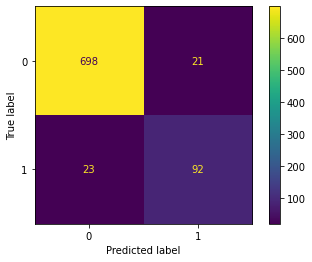

In [46]:
plot_confusion_matrix(gs.best_estimator_, X_test, y_test)

In [47]:
acc = accuracy_score(y_test, gs.best_estimator_.predict(X_test))
rec = recall_score(y_test, gs.best_estimator_.predict(X_test))
pre = precision_score(y_test, gs.best_estimator_.predict(X_test))
f1 = f1_score(y_test, gs.best_estimator_.predict(X_test))

In [48]:
print(f'f1 score is {f1}')

f1 score is 0.8070175438596492


In [49]:
y_hat = gs.best_estimator_.predict(X_test)  #print was acquired from davids lecture
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.95. 

Our final model's recall on the test set is 0.8 

Our final model's precision on the test set is 0.81 

Our final model's f1-score on the test is 0.81.

